# Data reduction for the hap-fr channel

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.convolution import Tophat2DKernel
from regions import CircleSkyRegion, RectangleSkyRegion

from gammapy.detect import compute_lima_on_off_image
from gammapy.data import DataStore
from gammapy.irf import make_mean_psf
from gammapy.maps import Map, MapAxis, WcsGeom
from gammapy.cube import (
    MapDatasetMaker,
    PSFKernel,
    MapDataset,
    RingBackgroundMaker,
    SafeMaskMaker,
    #RingBackgroundEstimator,
)
from gammapy.modeling.models import (
    SkyModel,
    BackgroundModel,
    PowerLawSpectralModel,
    PowerLaw2SpectralModel,
    PointSpatialModel,
    ExpCutoffPowerLawSpectralModel,
    SkyDiffuseCube,
    TemplateSpatialModel
)
from gammapy.modeling import Fit
from astropy.time import Time

src_pos = SkyCoord(359.94, -0.04, unit="deg", frame="galactic")

import gammapy
gammapy.__version__

'0.15'

In [2]:
from pathlib import Path

path = Path("$GAMMAPY_DATA/GC_variability2020")
path.mkdir(exist_ok=True)

path = Path("$GAMMAPY_DATA/GC_variability2020/hap-fr")
path.mkdir(exist_ok=True)

pathm = Path(path/"mapdatasets")
pathm.mkdir(exist_ok=True)

patho = Path(path/"offsets")
patho.mkdir(exist_ok=True)

pathz = Path(path/"angzen")
pathz.mkdir(exist_ok=True)

FileNotFoundError: [Errno 2] No such file or directory: '$GAMMAPY_DATA/GC_variability2020'

## Importing FoVBackground class (for pre 0.16 gammapy versions)

In [2]:
##FoV background estimation
import logging
from gammapy.maps import Map
from gammapy.modeling import Fit, Datasets


class FoVBackgroundMaker:
    """Normalize template background on the whole field-of-view.

    The dataset background model can be simply scaled (method="scale") or fitted (method="fit")
    on the dataset counts.

    The normalization is performed outside the exclusion mask that is passed on init.

    If a SkyModel is set on the input dataset and method is 'fit', its are frozen during
    the fov normalization fit.

    Parameters
    ----------
    method : str in ['fit', 'scale']
        the normalization method to be applied. Default 'scale'.
    exclusion_mask : `~gammapy.maps.WcsNDMap`
        Exclusion mask
    """

    def __init__(self, method="scale", exclusion_mask=None):
        if method in ["fit", "scale"]:
            self.method = method
        else:
            raise ValueError(f"Incorrect method for FoVBackgroundMaker: {method}.")
        self.exclusion_mask = exclusion_mask


    def run(self, dataset):
        """Run FoV background maker.

        Fit the background model norm

        Parameters
        ----------
        dataset : `~gammapy.cube.fit.MapDataset`
            Input map dataset.

        """
        mask_fit = dataset.mask_fit
        dataset.mask_fit = self._reproject_exclusion_mask(dataset)

        if self.method is "fit":
            self._fit_bkg(dataset)
        else:
            self._scale_bkg(dataset)

        dataset.mask_fit = mask_fit
        return dataset


    def _reproject_exclusion_mask(self, dataset):
        """Reproject the exclusion on the dataset geometry"""
        mask_map = Map.from_geom(dataset.counts.geom)
        if self.exclusion_mask is not None:
            coords = dataset.counts.geom.get_coord()
            vals = self.exclusion_mask.get_by_coord(coords)
            mask_map.data += vals

        return mask_map.data.astype("bool")

    def _fit_bkg(self, dataset):
        """Fit the FoV background model on the dataset counts data"""

        # freeze all model components not related to background model
        datasets = Datasets([dataset])

        parameters_frozen = []
        for par in datasets.parameters:
            parameters_frozen.append(par.frozen)
            if par not in dataset.background_model.parameters:
                par.frozen = True

        #!!!AL: relax titlt : BE CARREFULL !!!
        dataset.background_model.tilt.frozen=False
        
        fit = Fit(datasets)
        fit_result = fit.run()
        if fit_result.success is False:
            print("FoVBackgroundMaker failed. No fit convergence")
            

        # Unfreeze parameters
        for i, par in enumerate(datasets.parameters):
            par.frozen = parameters_frozen[i]

    def _scale_bkg(self, dataset):
        """Fit the FoV background model on the dataset counts data"""
        mask = dataset.mask
        count_tot = dataset.counts.data[mask].sum()
        bkg_tot = dataset.background_model.map.data[mask].sum()

        if count_tot <= 0.0:
            print("FoVBackgroundMaker failed. No counts found outside exclusion mask")
        elif bkg_tot <= 0.0:
            print("FoVBackgroundMaker failed. No positive background found outside exclusion mask")
        else:
            scale = count_tot / bkg_tot
            dataset.background_model.norm.value = scale
            #print("bkg scale = ",scale)

## Datastore creation

In [3]:
data_store = DataStore.from_dir("$GAMMAPY_DATA/ash_stereo_Prod17_Calib0834_thsq64")
data_store.info()

Data store:
HDU index table:
BASE_DIR: /home/samuel/code/gammapy_data/ash_stereo_Prod17_Calib0834_thsq64
Rows: 127056
OBS_ID: 18092 -- 154591
HDU_TYPE: ['aeff', 'bkg', 'edisp', 'events', 'gti', 'psf']
HDU_CLASS: ['aeff_2d', 'bkg_2d', 'edisp_2d', 'events', 'gti', 'psf_table']


Observation table:
Observatory name: 'N/A'
Number of observations: 21186



## Data selection

In [4]:
# Sky region selection : observation pointing within this region will be selected 
#(this can be redundant with maximum offset selection, but using the max_offset should be prefered)

from astropy.coordinates import Angle

selection = dict(type='sky_circle', frame='galactic',
                 lon=Angle(0, 'deg'),
                 lat=Angle(0, 'deg'),
                 radius=Angle(2, 'deg'),
                 border=Angle(0, 'deg'))


# selecting the admitted range of zenithal angle, such selection can be done for any column of the obs_table
selectionZEN = dict(type='par_box', variable='ZEN_PNT', value_range=Angle([0., 90.], 'deg'))

obs_table = data_store.obs_table.select_observations(selection)
obs_table = obs_table.select_observations(selectionZEN)

In [5]:
# Removing observations lacking IRFs (effective area, energy dispersion, point spread function and background model)

ids = obs_table["OBS_ID"].tolist()
observations = data_store.get_observations(ids, skip_missing=True)

for obs in observations:
    try:
        obs.aeff
        obs.edisp
        obs.psf
        obs.bkg
            
    except:
        ids.remove(obs.obs_id)
        print("Removed observations : " + str(obs.obs_id))
        
observations = data_store.get_observations(ids, skip_missing=True)
obs_table = obs_table.select_obs_id(ids)

Removed observations : 31539
Removed observations : 31577
Removed observations : 31578
Removed observations : 31579
Removed observations : 31580
Removed observations : 129467
Removed observations : 129471
Removed observations : 130931
Removed observations : 130942
Removed observations : 132321
Removed observations : 153792
Removed observations : 146971
Removed observations : 147119
Removed observations : 151790
Removed observations : 153030
Removed observations : 153031
Removed observations : 153791
Removed observations : 153793
Removed observations : 153794
Removed observations : 153810
Removed observations : 153811
Removed observations : 153812
Removed observations : 153813
Removed observations : 153836
Removed observations : 153837
Removed observations : 153838
Removed observations : 153839
Removed observations : 153840
Removed observations : 153841


### Grouping valid observations by year

In [6]:
#time intervals used for selection

t2004  = dict(type='time_box', time_range= Time(['2004-01-01T00:00:00', '2004-12-31T23:59:59']))
t2005  = dict(type='time_box', time_range= Time(['2005-01-01T00:00:00', '2005-12-31T23:59:59']))
t2006  = dict(type='time_box', time_range= Time(['2006-01-01T00:00:00', '2006-12-31T23:59:59']))
t2007  = dict(type='time_box', time_range= Time(['2007-01-01T00:00:00', '2007-12-31T23:59:59']))
t2008  = dict(type='time_box', time_range= Time(['2008-01-01T00:00:00', '2008-12-31T23:59:59']))
t2009  = dict(type='time_box', time_range= Time(['2009-01-01T00:00:00', '2009-12-31T23:59:59']))
t2010  = dict(type='time_box', time_range= Time(['2010-01-01T00:00:00', '2010-12-31T23:59:59']))
t2011  = dict(type='time_box', time_range= Time(['2011-01-01T00:00:00', '2011-12-31T23:59:59']))
t2012  = dict(type='time_box', time_range= Time(['2012-01-01T00:00:00', '2012-12-31T23:59:59']))
t2013  = dict(type='time_box', time_range= Time(['2013-01-01T00:00:00', '2013-12-31T23:59:59']))
t2014  = dict(type='time_box', time_range= Time(['2014-01-01T00:00:00', '2014-12-31T23:59:59']))
t2015  = dict(type='time_box', time_range= Time(['2015-01-01T00:00:00', '2015-12-31T23:59:59']))
t2016  = dict(type='time_box', time_range= Time(['2016-01-01T00:00:00', '2016-12-31T23:59:59']))
t2017  = dict(type='time_box', time_range= Time(['2017-01-01T00:00:00', '2017-12-31T23:59:59']))
t2018  = dict(type='time_box', time_range= Time(['2018-01-01T00:00:00', '2018-12-31T23:59:59']))
t2019  = dict(type='time_box', time_range= Time(['2019-01-01T00:00:00', '2019-12-31T23:59:59']))

In [7]:
year_intervals = { 2004 : t2004, 2005 : t2005, 2006 : t2006, 2007 : t2007,
                      2008 : t2008, 2009 : t2009, 2010 : t2010, 2011 : t2011,
                      2012 : t2012, 2013 : t2013, 2014 : t2014, 2015 : t2015,
                      2016 : t2016, 2017 : t2017, 2018 : t2018, 2019 : t2019}

yearly_obs = dict()

for year in range(2004,2020) :
    
    obs_table_year = obs_table.select_observations(year_intervals[year])
    ids = obs_table_year["OBS_ID"].tolist()
    observations_year = data_store.get_observations(ids, skip_missing=True)
    yearly_obs[year] = observations_year

## Creating the geometry for the dataset

In [8]:
emin, emax = [0.5, 100] * u.TeV

energy_axis = MapAxis.from_bounds(
    emin.value, emax.value, 20, unit="TeV", name="energy", interp="log"
)
geom = WcsGeom.create(
    skydir=(0, 0),
    binsz=0.02,
    width=(10, 8),
    coordsys="GAL",
    proj="CAR",
    axes=[energy_axis],
)

energy_axis_true = MapAxis.from_bounds(
    0.3, 200, 30, unit="TeV", name="energy", interp="log"
)

In [9]:
# Creating the MapDataset objects

mapdataset_tot = MapDataset.create(geom=geom, energy_axis_true=energy_axis_true, name="maptot")

mapdataset_dict = {}

for k in range (2004,2020):
    
    name = "map" + str(k)
    mapdataset_dict[k] = MapDataset.create(
    geom=geom, energy_axis_true=energy_axis_true, name=name)

## Dataset containing all the data

In [10]:
%%time

exclusion_region = RectangleSkyRegion(src_pos, 3*u.deg, 1*u.deg)
exclusion_mask = geom.region_mask([exclusion_region], inside=False)
exclusion_mask = Map.from_geom(geom, data=exclusion_mask)

offset_max = 1.8 * u.deg #on peut le réduire pour ne pas prendre les obs trop éloignées du centre de 2.0 deg à 1.8 deg
maker = MapDatasetMaker()
maker_safe_mask = SafeMaskMaker(methods=["offset-max", "bkg-peak"], offset_max=offset_max)
maker_bkg = FoVBackgroundMaker("scale", exclusion_mask)

spectrum = PowerLaw2SpectralModel(index=2.3)

for obs in observations:
        # First a cutout of the target map is produced
    cutout = mapdataset_dict[year].cutout(obs.pointing_radec, width=2 * offset_max)

        # A MapDataset is filled in this cutout geometry
    dataset = maker.run(cutout, obs)
        
        # The data quality cut is applied
    dataset = maker_safe_mask.run(dataset, obs)
    
    dataset = maker_bkg.run(dataset)
        
        # The resulting dataset cutout is stacked onto the final one
    mapdataset_dict[year].stack(dataset)

CPU times: user 16min 21s, sys: 2.85 s, total: 16min 24s
Wall time: 16min 25s


In [19]:
from pathlib import Path

path = Path("$GAMMAPY_DATA/GC_variability2020/hap-fr")
#path.mkdir(exist_ok=True)

In [11]:
filename = "mapdatasets/mapdataset_tot.fits.gz"
mapdataset_tot.write(path/filename, overwrite=True)

## Datasets for each year

In [12]:
%%time

exclusion_region = RectangleSkyRegion(src_pos, 3*u.deg, 1*u.deg)
exclusion_mask = geom.region_mask([exclusion_region], inside=False)
exclusion_mask = Map.from_geom(geom, data=exclusion_mask)

histo = dict()

for year in range(2004,2020):
    
    offset_max = 2.0 * u.deg #on peut le réduire pour ne pas prendre les obs trop éloignées du centre de 2.0 deg à 1.8 deg
    maker = MapDatasetMaker()
    maker_safe_mask = SafeMaskMaker(methods=["offset-max", "bkg-peak"], offset_max=offset_max)
    maker_bkg = FoVBackgroundMaker("scale", exclusion_mask)
    
    
    # au lieu de "scale" prendre "fit" en donnant au dataset un masque sur les bin en énergie (prendre à partir de 1 TeV par ex, même si c'est déjà haut 500 GeV)
    
    # ou alors on met "bkg-peak" pour le safemaskmaker (le premier bin en énergie est retiré)
    
    spectrum = PowerLaw2SpectralModel(index=2.3)

    for obs in yearly_obs[year]:
        # First a cutout of the target map is produced
        cutout = mapdataset_dict[year].cutout(obs.pointing_radec, width=2 * offset_max)

        # A MapDataset is filled in this cutout geometry
        dataset = maker.run(cutout, obs)
        
        # The data quality cut is applied
        dataset = maker_safe_mask.run(dataset, obs)
        
        
        dataset = maker_bkg.run(dataset)
        
        # The resulting dataset cutout is stacked onto the final one
        mapdataset_dict[year].stack(dataset)


CPU times: user 21min 49s, sys: 3.4 s, total: 21min 53s
Wall time: 21min 53s


In [13]:
for year in range(2004,2020):
    
    filename = "mapdatasets/mapdataset" +str(year)+".fits.gz"
    mapdataset_dict[year].write(path/filename, overwrite=True)

## Collecting data on observation conditions

FileNotFoundError: [Errno 2] No such file or directory: '$GAMMAPY_DATA/GC_variability2020/hap-fr/offsets/offsets_2004.pdf'

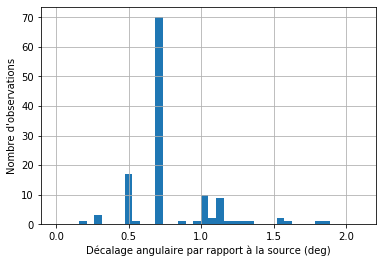

In [26]:
# Extracing offsets of observations (relative to SgrA*) for each year

sgra_pos = SkyCoord(359.94, -0.04, unit="deg", frame="galactic")

histo_offset = dict()

patho = Path(path/"offsets")
patho.mkdir(exist_ok=True)

for year in range(2004,2020):
    histo_offset[year] = []

    for obs in yearly_obs[year]:
        direction = obs.pointing_radec
        sep = direction.separation(sgra_pos) #calcule la séparation "on sky" entre les deux coordonnées
        histo_offset[year].append(sep.value)
        
    plt.figure()
    plt.hist(histo_offset[year], 40, (0.0, 2.1))
    
    plt.grid()
    plt.xlabel("Décalage angulaire par rapport à la source (deg)")
    plt.ylabel("Nombre d'observations")
    
    name = "offsets_"+str(year)+".pdf"
    plt.savefig(patho/name, overwrite=True)

In [ ]:
# Extracing zenithal angle of observation for each year

histo_zen = dict()

pathz = Path(path/"angzen")
pathz.mkdir(exist_ok=True)

for year in range(2004,2020):  
    histo_zen[year] = []
    
    obs_table_year = obs_table.select_observations(year_intervals[year])
    histo_zen[year] = obs_table_year["ZEN_PNT"].tolist()
    
    plt.figure()
    plt.hist(histo_zen[year], 40, (5.0, 65.0))
    
    plt.grid()
    plt.xlabel("Angle zénithal de l'observation (deg)")
    plt.ylabel("Nombre d'observations")
    
    name = "angzen_"+str(year)+".pdf"
    plt.savefig(pathz/name, overwrite=True)

FileNotFoundError: [Errno 2] No such file or directory: '$GAMMAPY_DATA/GC_variability2020/hap-fr/livetime_plot.pdf'

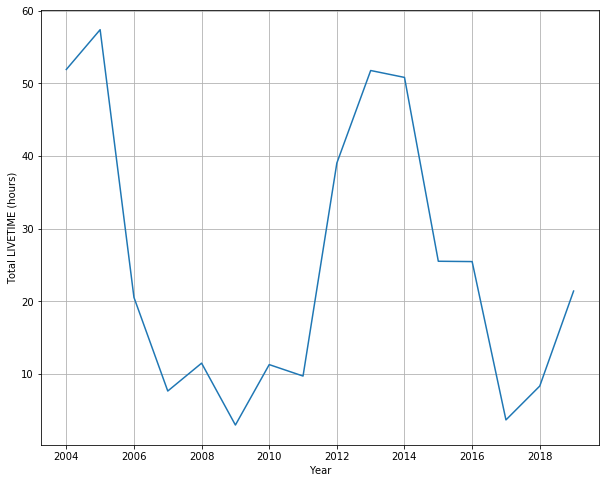

In [28]:
# Adding up LiveTime for each year

res = []

for year in range(2004,2020):
    obs_table_year = obs_table.select_observations(year_intervals[year])
    res.append(sum(obs_table_year["LIVETIME"].tolist())/3600)


plt.figure(figsize=(10,8))

plt.plot(range(2004,2020), res)
plt.grid()
plt.xlabel("Year")
plt.ylabel("Total LIVETIME (hours)")
    
name = path/"livetime_plot.pdf"
plt.savefig(name, overwrite=True)